In [1]:
# default_exp data.tsloader_general

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
from nixtla.data.tsdataset import TimeSeriesDataset
from collections import defaultdict

In [4]:
#export
# TODO: Check if the saturday zero protection is still in place
class TimeSeriesLoader(object):
    def __init__(self,
                 ts_dataset: TimeSeriesDataset,
                 model: str,
                 offset: int,
                 window_sampling_limit: int, 
                 input_size: int,
                 output_size: int,
                 idx_to_sample_freq: int,
                 batch_size: int,
                 is_train_loader: bool,
                 shuffle: bool,
                 random_seed: int
                 n_series_per_batch: int=None):
        """
        """
        # Dataloader attributes
        self.model = model
        self.window_sampling_limit = window_sampling_limit
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.idx_to_sample_freq = idx_to_sample_freq
        self.offset = offset
        self.ts_dataset = ts_dataset
        self.t_cols = self.ts_dataset.t_cols
        self.is_train_loader = is_train_loader # Boolean variable for train and validation mask
        if n_series_per_batch is not None:
            self.n_series_per_batch = n_series_per_batch 
        else:
            self.n_series_per_batch = min(batch_size, self.ts_dataset.n_series)
        self.windows_per_serie = self.batch_size // self.n_series_per_batch
        self.shuffle = shuffle
        self.random_seed = random_seed
        np.random.seed(self.random_seed)
        
        assert offset==0, 'sample_mask and offset interaction not implemented'
        assert window_sampling_limit==self.ts_dataset.max_len, \
            'sample_mask and window_samplig_limit interaction not implemented'        

        # Dataloader protections
        assert self.batch_size % self.n_series_per_batch == 0, \
                        f'batch_size {self.batch_size} must be multiple of n_series_per_batch {self.n_series_per_batch}'
        assert self.n_series_per_batch <= self.ts_dataset.n_series, \
                        f'n_series_per_batch {n_series_per_batch} needs to be smaller than n_series {self.ts_dataset.n_series}'
        assert offset < self.ts_dataset.max_len, \
            f'Offset {offset} must be smaller than max_len {self.ts_dataset.max_len}'

    def _get_sampleable_windows_idxs(self, ts_windows_flatten):        
        # Only sample during available windows with at least one active output mask and input mask
        #n_windows, n_channels, max_len
        #available_condition = t.sum(self.ts_windows[:, self.t_cols.index('available_mask'), :self.input_size], axis=1)
        sample_condition = t.sum(ts_windows_flatten[:, self.t_cols.index('sample_mask'), -self.output_size:], axis=1)
        sampling_idx = t.nonzero(sample_condition)

        sampling_idx = list(sampling_idx.flatten().numpy())
        assert len(sampling_idx)>0, 'Check the data and masks as sample_idxs are empty'
        return sampling_idx

    def _create_windows_tensor(self, ts_idxs=None):
        """
        Comment here
        TODO: Cuando creemos el otro dataloader, si es compatible lo hacemos funcion transform en utils
        """
        # Filter function is used to define train tensor and validation tensor with the offset
        # Default ts_idxs=ts_idxs sends all the data, otherwise filters series      
        tensor, right_padding = self.ts_dataset.get_filtered_ts_tensor(offset=self.offset, output_size=self.output_size,
                                                                       window_sampling_limit=self.window_sampling_limit,
                                                                       ts_idxs=ts_idxs)
        tensor = t.Tensor(tensor)

        # Outsample mask checks existance of values in ts, train_mask mask is used to filter out validation
        # is_train_loader inverts the train_mask in case the dataloader is in validation mode
        if self.is_train_loader:
            tensor[:, self.t_cols.index('sample_mask'), :] = \
                (tensor[:, self.t_cols.index('available_mask'), :] * tensor[:, self.t_cols.index('sample_mask'), :])
        else:
            tensor[:, self.t_cols.index('sample_mask'), :] = (1-tensor[:, self.t_cols.index('sample_mask'), :])
            
            # Since Xt from future is returned in tensor, protection from leakage is needed
            #tensor[:, self.t_cols.index('y'), -self.output_size:] = 0 # overkill to ensure no validation leakage
            #tensor[:, self.t_cols.index('sample_mask'), -self.output_size:] = 0

        padder = t.nn.ConstantPad1d(padding=(self.input_size, right_padding), value=0)
        tensor = padder(tensor)

        # Creating rolling windows and 'flattens' them
        windows = tensor.unfold(dimension=-1, size=self.input_size + self.output_size, step=self.idx_to_sample_freq)
        # n_serie, n_channel, n_time, window_size -> n_serie, n_time, n_channel, window_size
        #print(f'n_serie, n_channel, n_time, window_size = {windows.shape}')
        windows = windows.permute(0,2,1,3)
        #print(f'n_serie, n_time, n_channel, window_size = {windows.shape}')
        windows = windows.reshape(-1, self.ts_dataset.n_channels, self.input_size + self.output_size)

        # Broadcast s_matrix: This works because unfold in windows_tensor, orders: serie, time
        s_matrix = self.ts_dataset.s_matrix[ts_idxs]
        windows_per_serie = len(windows)//len(ts_idxs)
        s_matrix = s_matrix.repeat(repeats=windows_per_serie, axis=0)

        return windows, s_matrix

    def __iter__(self):
        n_series = self.ts_dataset.n_series
        # Shuffle idx before epoch if self._is_train
        if self.shuffle:
            sample_idxs = np.random.choice(a=range(n_series), size=n_series, replace=False)
        else:
            sample_idxs = np.array(range(n_series))

        n_batches = int(np.ceil(n_series / self.n_series_per_batch)) # Must be multiple of batch_size for paralel gpu

        for idx in range(n_batches):
            ts_idxs = sample_idxs[(idx * self.n_series_per_batch) : (idx + 1) * self.n_series_per_batch]
            batch = self.__get_item__(index=ts_idxs)
            yield batch

    def __get_item__(self, index):
        if (self.model == 'nbeats') or (self.model == 'tcn'):
            return self._windows_batch(index)
        elif self.model == 'esrnn':
            return self._full_series_batch(index)
        else:
            assert 1<0, 'error'

    def _windows_batch(self, index):
        """ NBEATS, TCN models """

        # Create windows for each sampled ts and sample random unmasked windows from each ts
        windows, s_matrix = self._create_windows_tensor(ts_idxs=index)
        sampleable_windows = self._get_sampleable_windows_idxs(ts_windows_flatten=windows)
        self.sampleable_windows = sampleable_windows

        # Get sample windows_idxs of batch
        if self.shuffle:
            windows_idxs = np.random.choice(sampleable_windows, self.batch_size, replace=True)
        else:
            windows_idxs = sampleable_windows
        
        # Index the windows and s_matrix tensors of batch
        windows = windows[windows_idxs]
        s_matrix = s_matrix[windows_idxs]

        # Parse windows to elements of batch
        insample_y = windows[:, self.t_cols.index('y'), :self.input_size]
        insample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('available_mask'), :self.input_size]
        available_mask = windows[:, self.t_cols.index('available_mask'), :self.input_size]

        outsample_y = windows[:, self.t_cols.index('y'), self.input_size:]
        outsample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('available_mask'), self.input_size:]
        sample_mask = windows[:, self.t_cols.index('sample_mask'), self.input_size:]

        batch = {'s_matrix': s_matrix,
                 'insample_y': insample_y, 'insample_x':insample_x, 'insample_mask':available_mask,
                 'outsample_y': outsample_y, 'outsample_x':outsample_x, 'outsample_mask':sample_mask}
        return batch

    def _full_series_batch(self, index):
        """ ESRNN, RNN models """

        ts_tensor, _, _ = self.ts_dataset.get_filtered_ts_tensor(offset=self.offset, output_size=self.output_size,
                                                                 window_sampling_limit=self.window_sampling_limit,
                                                                 ts_idxs=index)
        # Trim batch to shorter time series to avoid zero padding
        insample_y = ts_tensor[:, self.t_cols.index('y'), :]
        batch_len_series = np.array(self.ts_dataset.len_series)[index]
        min_batch_len = np.min(batch_len_series)
        insample_y = insample_y[:, -min_batch_len:]

        insample_x = ts_tensor[:, self.t_cols.index('y')+1:self.t_cols.index('available_mask'), :]
        insample_x = insample_x[:, -min_batch_len:]

        s_matrix = self.ts_dataset.s_matrix[index]

        batch = {'insample_y': insample_y, 'idxs': index, 'insample_x': insample_x, 's_matrix': s_matrix}

        return batch

    def update_offset(self, offset):
        if offset == self.offset:
            return # Avoid extra computation
        self.offset = offset

    def get_meta_data_col(self, col):
        return self.ts_dataset.get_meta_data_col(col)

    def get_n_variables(self):
        return self.ts_dataset.n_x, self.ts_dataset.n_s

    def get_n_series(self):
        return self.ts_dataset.n_series

    def get_max_len(self):
        return self.ts_dataset.max_len

    def get_n_channels(self):
        return self.ts_dataset.n_channels

    def get_X_cols(self):
        return self.ts_dataset.X_cols

    def get_frequency(self):
        return self.ts_dataset.frequency

    def train(self):
        self._is_train = True

    def eval(self):
        self._is_train = False

In [5]:
import matplotlib.pyplot as plt
from nixtla.data.datasets.m4 import M4, M4Info
print(M4Info.groups[0])
Y_df = M4.load(directory='../data', group=M4Info.groups[0])

Yearly


In [6]:
Y_df.groupby('unique_id')['y'].count().max()

def get_last_n_timestamps_mask_df(Y_df, n_timestamps):
    # Creates outsample_mask
    # train 1 validation 0

    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(n_timestamps)
    last_df['mask'] = 1

    last_df = last_df[['unique_id', 'ds', 'mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['mask'] = mask_df['mask'].fillna(0)    # The first len(Y)-n_hours used as train

    mask_df = mask_df[['unique_id', 'ds', 'mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    return mask_df

mask_df = get_last_n_timestamps_mask_df(Y_df, n_timestamps=5)
mask_df['available_mask'] = np.ones(len(mask_df))
mask_df['sample_mask'] = (1-mask_df['mask'].values)

In [7]:
m4_dataset = TimeSeriesDataset(Y_df=Y_df, mask_df=mask_df)

Train Validation splits
                       ds    
                      min max
unique_id sample_mask        
Y1        0.0          33  37
          1.0           1  32
Y10       0.0          21  25
          1.0           1  20
Y100      0.0          56  60
...                    ..  ..
Y9997     1.0           1  25
Y9998     0.0          26  30
          1.0           1  25
Y9999     0.0          26  30
          1.0           1  25

[46000 rows x 2 columns]
Total data 			858458 time stamps
Available prc = 1.0, 		858458.0 time stamps
Train prc = 0.86604, 		743458.0 time stamps
Predict prc = 0.13396, 		115000.0 time stamps




In [8]:
m4_dataset.ts_tensor.shape

(23000, 3, 841)

In [9]:
ts_loader = TimeSeriesLoader(ts_dataset=m4_dataset,
                             model='nbeats',
                             offset=0,
                             window_sampling_limit=m4_dataset.max_len, 
                             input_size=30,
                             output_size=6,
                             idx_to_sample_freq=1,
                             batch_size=1024,
                             is_train_loader=True,
                             shuffle=False)

In [10]:
input_size = 30
output_size = 6

# For shuffle bool testing purpose
tensor,right_padding = m4_dataset.get_filtered_ts_tensor(offset=0, output_size=output_size,
                                                         window_sampling_limit=m4_dataset.max_len,
                                                         ts_idxs=np.array(range(23000)))

In [11]:
dataloader = iter(ts_loader)
batch = next(dataloader)
insample_y = batch['insample_y']
insample_x_t = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_y = batch['outsample_y']
outsample_x = batch['outsample_x']
outsample_mask = batch['outsample_mask']

print("m4_dataset.t_cols", m4_dataset.t_cols)
print("ts_loader.input_size", ts_loader.input_size)
print("ts_loader.output_size", ts_loader.output_size)
print("insample_y.shape", insample_y.shape)
print("outsample_y.shape", outsample_y.shape)
print("tensor.shape", tensor.shape)

m4_dataset.t_cols ['y', 'available_mask', 'sample_mask']
ts_loader.input_size 30
ts_loader.output_size 6
insample_y.shape torch.Size([37520, 30])
outsample_y.shape torch.Size([37520, 6])
tensor.shape (23000, 3, 841)


In [12]:
insample_y

tensor([[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        ...,
        [2130., 2030., 2108.,  ..., 4901., 4976., 5080.],
        [2030., 2108., 2265.,  ..., 4976., 5080., 5073.],
        [2108., 2265., 2266.,  ..., 5080., 5073., 5116.]])

In [13]:
outsample_y

tensor([[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000, 5172.1001],
        [   0.0000,    0.0000,    0.0000,    0.0000, 5172.1001, 5133.5000],
        [   0.0000,    0.0000,    0.0000, 5172.1001, 5133.5000, 5186.8999],
        ...,
        [5073.0000, 5116.0000, 4937.0000, 4994.0000, 4897.0000, 4916.0000],
        [5116.0000, 4937.0000, 4994.0000, 4897.0000, 4916.0000, 4813.0000],
        [4937.0000, 4994.0000, 4897.0000, 4916.0000, 4813.0000, 4886.0000]])

Checking order for unshuffled validation


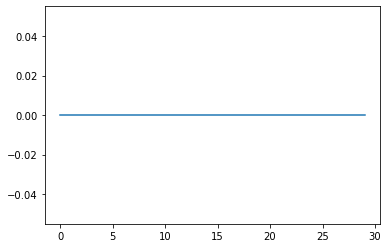

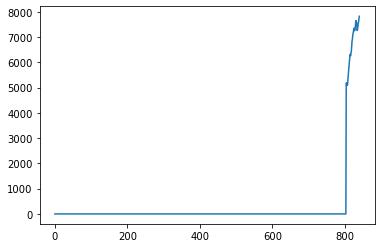

In [14]:
ts_loader.shuffle = False
dataloader = iter(ts_loader)
batch = next(dataloader)
insample_y = batch['insample_y']

print("Checking order for unshuffled validation")
plt.plot(insample_y[0,:])
plt.show()

plt.plot(tensor[0,0,:])
plt.show()

# TOY EXAMPLE

In [15]:
import numpy as np
import pandas as pd

n_weeks = 2

Y = np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X1 = -np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X2 = 1/(np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])+1)

unique_id = np.array(['u1']*168*2 + ['u2']*168*2)
ds = pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list() + \
     pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list()

X_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'X1': X1, 'X2': X2})
Y_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'y': Y})
S_df = Y_df.drop_duplicates('unique_id')[['unique_id']].reset_index(drop=True)
S_df['s_0'] = [1,0]
S_df['s_1'] = [0,1]

mask_df = get_last_n_timestamps_mask_df(Y_df, n_timestamps=5)
mask_df['available_mask'] = np.ones(len(mask_df))
mask_df['sample_mask'] = (1-mask_df['mask'].values)

In [16]:
Y_df

,unique_id,ds,y
0,u1,2018-01-01 00:00:00,0
1,u1,2018-01-01 01:00:00,1
2,u1,2018-01-01 02:00:00,2
3,u1,2018-01-01 03:00:00,3
4,u1,2018-01-01 04:00:00,4
...,...,...,...
667,u2,2018-01-14 19:00:00,3310
668,u2,2018-01-14 20:00:00,3320
669,u2,2018-01-14 21:00:00,3330
670,u2,2018-01-14 22:00:00,3340


In [17]:
toy_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, mask_df=mask_df)

Train Validation splits
                                       ds                    
                                      min                 max
unique_id sample_mask                                        
u1        0.0         2018-01-14 19:00:00 2018-01-14 23:00:00
          1.0         2018-01-01 00:00:00 2018-01-14 18:00:00
u2        0.0         2018-01-14 19:00:00 2018-01-14 23:00:00
          1.0         2018-01-01 00:00:00 2018-01-14 18:00:00
Total data 			672 time stamps
Available prc = 1.0, 		672.0 time stamps
Train prc = 0.98512, 		662.0 time stamps
Predict prc = 0.01488, 		10.0 time stamps




In [18]:
ts_loader = TimeSeriesLoader(ts_dataset=toy_dataset,
                             model='nbeats',
                             offset=0,
                             window_sampling_limit=toy_dataset.max_len,
                             input_size=5,
                             output_size=5,
                             idx_to_sample_freq=24,
                             batch_size=256,
                             is_train_loader=True,
                             shuffle=False)

In [19]:
dataloader = iter(ts_loader)
batch = next(dataloader)
insample_y = batch['insample_y']
insample_x_t = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_y = batch['outsample_y']
outsample_x = batch['outsample_x']
outsample_mask = batch['outsample_mask']
s_matrix = batch['s_matrix']

print("m4_dataset.t_cols", m4_dataset.t_cols)
print("ts_loader.input_size", ts_loader.input_size)
print("ts_loader.output_size", ts_loader.output_size)
print("insample_y.shape", insample_y.shape)
print("outsample_y.shape", outsample_y.shape)
print("s_matrix.shape", s_matrix.shape)

m4_dataset.t_cols ['y', 'available_mask', 'sample_mask']
ts_loader.input_size 5
ts_loader.output_size 5
insample_y.shape torch.Size([28, 5])
outsample_y.shape torch.Size([28, 5])
s_matrix.shape (28, 2)


In [20]:
insample_y

tensor([[   0.,    0.,    0.,    0.,    0.],
        [  19.,   20.,   21.,   22.,   23.],
        [  43.,   44.,   45.,   46.,   47.],
        [  67.,   68.,   69.,   70.,   71.],
        [  91.,   92.,   93.,   94.,   95.],
        [ 115.,  116.,  117.,  118.,  119.],
        [ 139.,  140.,  141.,  142.,  143.],
        [ 163.,  164.,  165.,  166.,  167.],
        [ 187.,  188.,  189.,  190.,  191.],
        [ 211.,  212.,  213.,  214.,  215.],
        [ 235.,  236.,  237.,  238.,  239.],
        [ 259.,  260.,  261.,  262.,  263.],
        [ 283.,  284.,  285.,  286.,  287.],
        [ 307.,  308.,  309.,  310.,  311.],
        [   0.,    0.,    0.,    0.,    0.],
        [ 190.,  200.,  210.,  220.,  230.],
        [ 430.,  440.,  450.,  460.,  470.],
        [ 670.,  680.,  690.,  700.,  710.],
        [ 910.,  920.,  930.,  940.,  950.],
        [1150., 1160., 1170., 1180., 1190.],
        [1390., 1400., 1410., 1420., 1430.],
        [1630., 1640., 1650., 1660., 1670.],
        [1

In [21]:
outsample_y

tensor([[0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00],
        [2.4000e+01, 2.5000e+01, 2.6000e+01, 2.7000e+01, 2.8000e+01],
        [4.8000e+01, 4.9000e+01, 5.0000e+01, 5.1000e+01, 5.2000e+01],
        [7.2000e+01, 7.3000e+01, 7.4000e+01, 7.5000e+01, 7.6000e+01],
        [9.6000e+01, 9.7000e+01, 9.8000e+01, 9.9000e+01, 1.0000e+02],
        [1.2000e+02, 1.2100e+02, 1.2200e+02, 1.2300e+02, 1.2400e+02],
        [1.4400e+02, 1.4500e+02, 1.4600e+02, 1.4700e+02, 1.4800e+02],
        [1.6800e+02, 1.6900e+02, 1.7000e+02, 1.7100e+02, 1.7200e+02],
        [1.9200e+02, 1.9300e+02, 1.9400e+02, 1.9500e+02, 1.9600e+02],
        [2.1600e+02, 2.1700e+02, 2.1800e+02, 2.1900e+02, 2.2000e+02],
        [2.4000e+02, 2.4100e+02, 2.4200e+02, 2.4300e+02, 2.4400e+02],
        [2.6400e+02, 2.6500e+02, 2.6600e+02, 2.6700e+02, 2.6800e+02],
        [2.8800e+02, 2.8900e+02, 2.9000e+02, 2.9100e+02, 2.9200e+02],
        [3.1200e+02, 3.1300e+02, 3.1400e+02, 3.1500e+02, 3.1600e+02],
        [0.0000e+00,

In [22]:
s_matrix

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])